In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

import matplotlib as mpl
#mpl.rcParams["figure.figsize"] = [8,6] # or 7, 4 or 10,8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['font.serif'] = ['Computer Modern']


# https://stackoverflow.com/a/17967324
from matplotlib import rc
rc('text', usetex=True)

In [2]:
# True weights and starting weights

np.random.seed(17)

d1 = 10
d2 = 1

m_true = 50
A_true = np.random.randn(m_true,d1)*np.sqrt(2/m_true)
B_true = np.random.randn(m_true,m_true)*np.sqrt(2/m_true)
C_true = np.random.randn(d2,m_true)*np.sqrt(1/d2)

m = 50
A0 = np.random.randn(m,d1)*np.sqrt(2/m)
B0 = np.random.randn(m,m)*np.sqrt(2/m)
C0 = np.random.randn(d2,m)*np.sqrt(1/d2)

In [3]:
def relu(x):
    y = np.maximum(0,x)
    return y

def grad(A,B,C,x,y):
    m = np.shape(B)[0]
    D1 = np.zeros(m)
    D2 = np.zeros(m)
    z = A@x
    D1[z >= 0] = 1
    D1 = np.diag(D1)
    D1Ax = D1@z
    z = B@D1Ax
    D2[z >= 0] = 1
    D2 = np.diag(D2)
    D2BD1Ax = D2@z
    z = C@D2BD1Ax-y
    obj = .5*la.norm(z)**2
    CD2 = C@D2
    CD2BD1 = CD2@B@D1
    der_A = np.outer(CD2BD1.T@z,x)
    der_B = np.outer(CD2.T@z,D1Ax)
    der_C = np.outer(z,D2BD1Ax)
    return [obj,der_A,der_B,der_C]

def gradset(A,B,C,X,Y):
    # TODO: can we vectorize this??
    
    n = np.shape(X)[0]
    objset = 0
    derset_A = np.zeros(np.shape(A))
    derset_B = np.zeros(np.shape(B))
    derset_C = np.zeros(np.shape(C))
    for i in range(n):
        x = X[i,:]
        y = Y[i,:]
        [obj,der_A,der_B,der_C] = grad(A,B,C,x,y)
        objset += obj
        derset_A += der_A
        derset_B += der_B
        derset_C += der_C
    objset /= n
    derset_A /= n
    derset_B /= n
    derset_C /= n
    return [objset,derset_A,derset_B,derset_C]

In [4]:
def sgd(A, B, C, A_true, B_true, C_true, step_size, niter, batch_size, n_test, niter_test, n_validation):
    
    
    # draw niter_test iterates
    p = np.arange(niter)
    p = 1/np.sqrt(p+1)
    p = p/np.sum(p)
    sampled_iterates = np.random.choice(niter,size=niter_test,replace=True,p=p)
    sampled_iterates = np.unique(sampled_iterates)
    sampled_iterate_index = 0
    sampled_iterate = sampled_iterates[sampled_iterate_index]
    sampled_iterate_final = sampled_iterates[len(sampled_iterates)-1]
    
    
    # draw test and validation sets
    d1 = np.shape(A)[1]
    
    X_test = np.random.randn(n_test,d1)
    X_test /= la.norm(X_test,axis=1).reshape(n_test,1)
    Y_test = np.transpose(C_true@relu(B_true@relu(A_true@X_test.T)))
    
    X_validation = np.random.randn(n_validation,d1)
    X_validation /= la.norm(X_validation,axis=1).reshape(n_validation,1)
    Y_validation = np.transpose(C_true@relu(B_true@relu(A_true@X_validation.T)))
    

    # apply sgd
    i = 0
    error = np.inf
    while i <= sampled_iterate_final:
        
        # draw stochastic gradient
        if batch_size == 1:
            x = np.random.randn(d1)
            x /= la.norm(x)
            y = C_true@relu(B_true@relu(A_true@x))
            [obj,der_A,der_B,der_C] = grad(A,B,C,x,y)
        else:
            X = np.random.randn(batch_size,d1)
            X /= la.norm(X,axis=1).reshape(batch_size,1)
            Y = np.transpose(C_true@relu(B_true@relu(A_true@X.T)))
            [obj,der_A,der_B,der_C] = gradset(A,B,C,X,Y)
        
        # take gradient step
        eta = step_size/np.sqrt(i+1)
        A = A-eta*der_A
        B = B-eta*der_B
        C = C-eta*der_C
        
        # compute test error for sampled iterates
        if i == sampled_iterate:
            [obj,der_A,der_B,der_C] = gradset(A,B,C,X_test,Y_test)
            new_error = la.norm(der_A)**2+la.norm(der_B)**2+la.norm(der_C)**2
            if new_error < error:
                error = new_error
                A_best = A
                B_best = B
                C_best = C
            if sampled_iterate != sampled_iterate_final:
                sampled_iterate_index += 1
                sampled_iterate = sampled_iterates[sampled_iterate_index]
        i += 1
        
        
    # compute validation error for best iterate
    A = A_best
    B = B_best
    C = C_best
    [obj,der_A,der_B,der_C] = gradset(A,B,C,X_validation,Y_validation)
    error = la.norm(der_A)**2+la.norm(der_B)**2+la.norm(der_C)**2
    
    return error

In [9]:
step_size = .1
niter = 1000
batch_size = 10
n_test = 1000
niter_test = 200
n_validation = 5000

num_trials = 100
errors = np.zeros(num_trials)
for i in range(num_trials):
    A = A0
    B = B0
    C = C0
    error = sgd(A, B, C, A_true, B_true, C_true, step_size, niter, batch_size, n_test, niter_test, n_validation)
    errors[i] = error
    print([i,error])

[0, 0.01228000477932662]
[1, 0.013267098591001556]
[2, 0.009753908257628266]
[3, 0.014974299567325336]
[4, 0.010147883026086631]
[5, 0.01228958369006012]
[6, 0.01180718467710671]
[7, 0.010126164846004818]
[8, 0.01225894717790794]
[9, 0.011524952858891718]
[10, 0.00952150998126917]
[11, 0.010934083386815542]
[12, 0.010793842487161923]
[13, 0.01285231803054335]
[14, 0.011170950966315481]
[15, 0.01314151024874825]
[16, 0.016102430775845743]
[17, 0.015154127431636143]
[18, 0.010989435204925025]
[19, 0.010141433852975655]
[20, 0.009000656294106783]
[21, 0.010730470025040368]
[22, 0.01137875386354342]
[23, 0.01644083315009155]
[24, 0.010826366688699867]
[25, 0.01829595660670093]
[26, 0.010334234491685166]
[27, 0.013015769431990086]
[28, 0.011899883022066904]
[29, 0.012636159694634521]
[30, 0.010688408528517023]
[31, 0.009535036743908808]
[32, 0.01401622029152076]
[33, 0.009956518858727436]
[34, 0.009189454968290267]
[35, 0.011283275751219107]
[36, 0.009442283162369511]
[37, 0.013957574932293

In [20]:
np.savez_compressed('SGD-Convergence_Data_11-03-2021', errors)

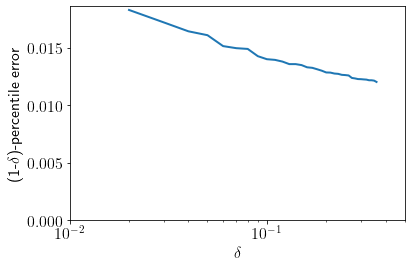

In [19]:
errors = np.sort(errors)
cdf = np.arange(len(errors))/float(len(errors))
idx1 = int(len(errors)-np.floor(len(errors)/np.e))
idx2 = len(errors)-1


fig, ax = plt.subplots()
# ax.plot(np.log(1/(1-cdf[idx1:idx2])),errors[idx1:idx2],'-')
ax.semilogx((1-cdf[idx1:idx2]),errors[idx1:idx2],'-')
# plt.xlabel('log(1/delta)')
plt.xlabel('$\delta$')
plt.ylabel('(1-$\delta$)-percentile error')
plt.ylim(bottom=0)
plt.xlim(left=.01,right=.5)
plt.savefig('convergence.pdf')
plt.show()